In [1]:
!python3 -m pip install -r requirements.txt >> install_logs.txt

In [2]:
import pandas as pd
import numpy as np
import missingno

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

PATH_TO_HISTORY_DATA = "data/history_data.csv"
SEED = 404

In [3]:
history_data = pd.read_csv(PATH_TO_HISTORY_DATA, encoding='UTF-16')
history_data.sample(5, random_state=SEED)

,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,...,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,WAVAL,TRADINGSESSION,CURRENCYID,TRENDCLSPR
53088,TQBR,2018-10-12,МКБ ао,CBOM,2471,25820189.3,4.98,4.98,5.055,5.045,...,5.043,5.043,5.045,25820189.3,25820189.3,25820189.3,NaN,3,SUR,0.50
25466,TQBR,2018-05-22,АЛРОСА-Нюр,ALNU,7,2655000.0,136000.00,132500.00,136000.000,132500.000,...,133500.000,133000.000,132500.000,3335500.0,3195500.0,3335500.0,NaN,3,SUR,-0.38
21675,TQBR,2018-04-28,ЮжКузб. ао,UKUZ,9,27080.0,775.00,735.00,780.000,740.000,...,NaN,735.000,740.000,0.0,507745.0,0.0,NaN,3,SUR,-5.16
43605,TQBR,2018-08-23,ТНСэнРст,RTSB,0,0.0,NaN,NaN,NaN,0.314,...,NaN,0.364,0.314,0.0,505490.0,0.0,NaN,3,SUR,-100.00
5811,TQBR,2018-02-02,РОСИНТЕРао,ROST,56,78743.0,65.10,62.00,65.400,62.800,...,NaN,64.800,62.800,0.0,509249.0,0.0,NaN,3,SUR,-3.38


In [6]:
history_data.columns

Index(['BOARDID', 'TRADEDATE', 'SHORTNAME', 'SECID', 'NUMTRADES', 'VALUE',
       'OPEN', 'LOW', 'HIGH', 'LEGALCLOSEPRICE', 'WAPRICE', 'CLOSE', 'VOLUME',
       'MARKETPRICE2', 'MARKETPRICE3', 'ADMITTEDQUOTE', 'MP2VALTRD',
       'MARKETPRICE3TRADESVALUE', 'ADMITTEDVALUE', 'WAVAL', 'TRADINGSESSION',
       'CURRENCYID', 'TRENDCLSPR'],
      dtype='object')

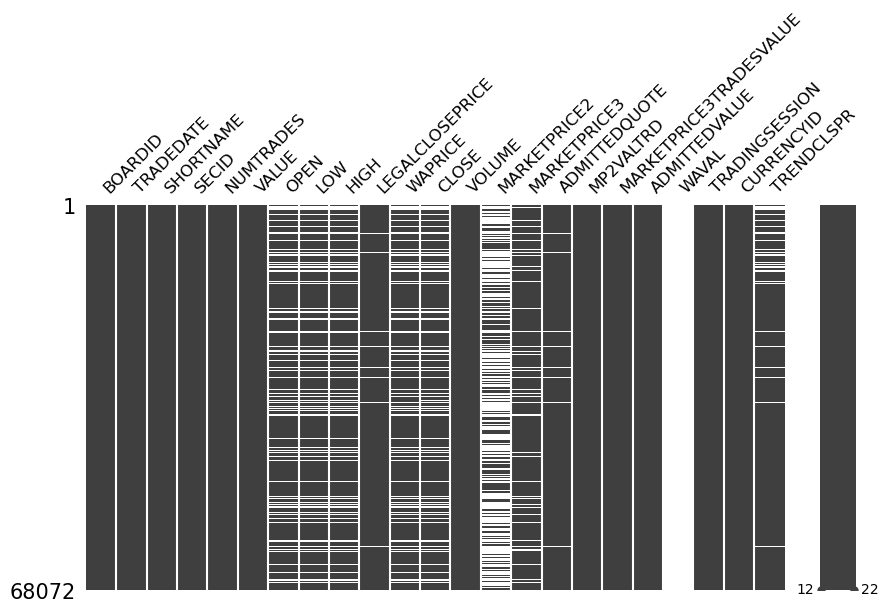

In [4]:
missingno.matrix(history_data, figsize=(10,5), fontsize=12);

Можно будет посмотреть потом какие перепады в ценах были (LOW, HIGH). Построить график и например сделать вывод о нестабильности кого-то.

Еще можно поиграться с VOLUME AND NUMTRADES

In [4]:
COLUMNS_TO_DROP = [
    "BOARDID",
    "SHORTNAME",
    "VALUE",
    "OPEN",
    "LOW",
    "HIGH",
    "WAPRICE",
    "MARKETPRICE2",
    "MARKETPRICE3",
    "ADMITTEDQUOTE",
    "MP2VALTRD",
    "MARKETPRICE3TRADESVALUE",
    "ADMITTEDVALUE",
    "WAVAL",
    "TRADINGSESSION",
    "CURRENCYID",
]
history_data = history_data.drop(columns=COLUMNS_TO_DROP)
history_data.sample(5, random_state=SEED)

,TRADEDATE,SECID,NUMTRADES,LEGALCLOSEPRICE,CLOSE,VOLUME,TRENDCLSPR
53088,2018-10-12,CBOM,2471,5.045,5.045,5119900,0.50
25466,2018-05-22,ALNU,7,132500.000,132500.000,20,-0.38
21675,2018-04-28,UKUZ,9,740.000,735.000,35,-5.16
43605,2018-08-23,RTSB,0,0.314,NaN,0,-100.00
5811,2018-02-02,ROST,56,62.800,62.800,1250,-3.38


In [5]:
num_trade_day = history_data.groupby(by="SECID", as_index=False).aggregate({"TRADEDATE": "count"}).TRADEDATE.unique()
print("Всего акций до обработки:", history_data.SECID.nunique())
print("Кол-во наблюдений за каждой акцией:", num_trade_day)

Всего акций до обработки: 268
Кол-во наблюдений за каждой акцией: [254]


Если акция не торгуется больше, чем 25 дней, то мы убираем такую акцию.
Кол-во акций, которое придется убрать: 100
Кол-во акций, которое остается: 168


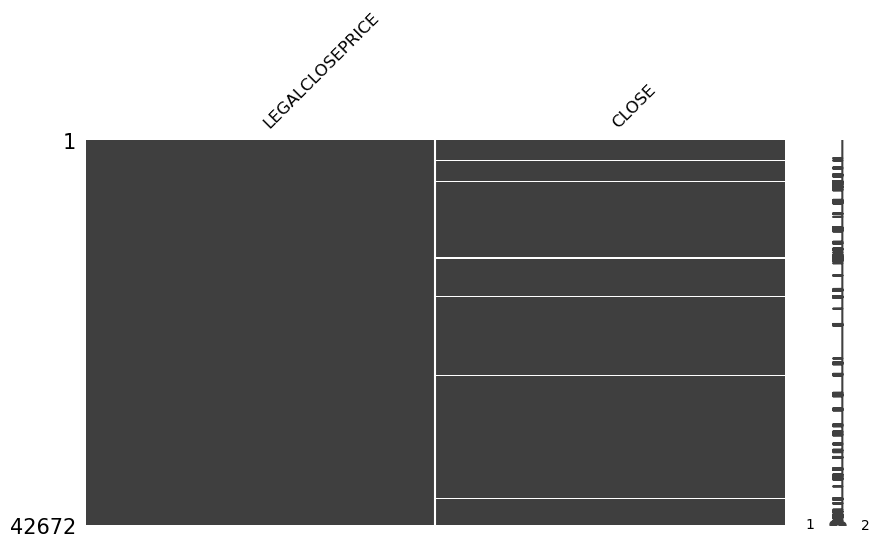

In [6]:
NO_TRADES_DAY = 25
no_trades_data = history_data[history_data.NUMTRADES == 0].groupby(by=["SECID"], as_index=False).count()

stocks_to_drop = no_trades_data[no_trades_data.NUMTRADES > NO_TRADES_DAY].SECID
data_after_drop = history_data[~history_data.SECID.isin(stocks_to_drop)]

print(f"Если акция не торгуется больше, чем {NO_TRADES_DAY} дней, то мы убираем такую акцию.")
print("Кол-во акций, которое придется убрать:", len(stocks_to_drop))
print("Кол-во акций, которое остается:", history_data.SECID.nunique() - len(stocks_to_drop))

missingno.matrix(data_after_drop.sort_values(by=["SECID", "TRADEDATE"])[["LEGALCLOSEPRICE", "CLOSE"]], figsize=(10,5), fontsize=12);

In [7]:
from functions import get_df_with_return
data_with_return = get_df_with_return(data_after_drop, first_day_value=0.0)
data_with_return.sort_values(by=["SECID", "TRADEDATE"])

,TRADEDATE,SECID,NUMTRADES,LEGALCLOSEPRICE,CLOSE,VOLUME,TRENDCLSPR,RETURN
1,2018-01-03,AFKS,5071,12.350,12.350,20687500,2.15,0.000000
269,2018-01-04,AFKS,4362,12.385,12.385,14880200,0.28,0.002830
537,2018-01-05,AFKS,3666,12.390,12.390,11072000,0.04,0.000404
805,2018-01-09,AFKS,9167,12.715,12.715,30905600,2.62,0.025893
1073,2018-01-10,AFKS,4446,12.700,12.700,11774300,-0.12,-0.001180
...,...,...,...,...,...,...,...,...
66999,2018-12-25,ZVEZ,15,4.650,4.620,26000,-0.65,0.000000
67267,2018-12-26,ZVEZ,6,4.700,4.700,6000,1.73,0.010695
67535,2018-12-27,ZVEZ,7,4.650,4.650,20000,-1.06,-0.010695
67803,2018-12-28,ZVEZ,21,4.660,4.660,60000,0.22,0.002148


In [19]:
# Посмотрим сколько дней доходность никакая. 
data_with_return[data_with_return.RETURN == 0.0]\
    .groupby(by="SECID", as_index=False)\
    .aggregate({"RETURN":"count"})\
    .rename(columns={"RETURN": "DAYS OF ZERO RETURN"})\
    .sort_values(by="DAYS OF ZERO RETURN", ascending=False)

,SECID,DAYS OF ZERO RETURN
97,OPIN,111
7,AVAZ,75
8,AVAZP,72
112,RLMN,71
147,TNSE,70
...,...,...
85,MTLR,2
118,RSTI,1
126,SBERP,1
64,MAGN,1


Так как таких дней не очень много, то пока оставим эти данные

In [24]:
# Посмотрим на ликвидность
data_with_return[data_with_return.VOLUME == 0]\
    .groupby(by="SECID", as_index=False)\
    .aggregate({"VOLUME": "count"})\
    .rename(columns={"VOLUME": "DAYS OF ZERO VOLUME"})\
    .sort_values(by="DAYS OF ZERO VOLUME", ascending=False)\
    .head(10)

,SECID,DAYS OF ZERO VOLUME
0,AVAZ,25
1,AVAZP,25
19,KRSBP,24
42,TNSE,23
4,CLSB,22
31,RKKE,22
12,HALS,20
39,TANL,18
24,MGTS,18
49,WTCM,17


Она тоже не очень плохая, поэтому пока отсекать ничего не будем